# Bert 방식
- Bert 사전학습 모델 사용

# 라이브러리 확인

In [1]:
import transformers, torch
transformers.__version__, torch.__version__

C:\Users\Admin\Desktop\ml_dl\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('4.52.4', '2.7.1+cu118')

In [2]:
!uv pip install accelerate

Using Python 3.11.12 environment at: C:\Users\Admin\Desktop\ml_dl\.venv
Audited 1 package in 7ms


In [3]:
# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 처리를 위한 pandas
import numpy as np  # 수치 연산을 위한 numpy
import torch  # 딥러닝 프레임워크
from torch.utils.data import Dataset  # 커스텀 데이터셋 생성을 위한 클래스
from sklearn.model_selection import train_test_split  # 데이터 분할
from sklearn.metrics import accuracy_score  # 정확도 계산
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback  # BERT 모델 관련
from datetime import datetime  # 시간 기록
import matplotlib.pyplot as plt  # 시각화
from transformers import EarlyStoppingCallback  # 조기 종료

# 기본값 설정

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
model_name = "bert-base-uncased"
submission_filename = f"submission_{model_name}_{current_time}.csv"
submission_filename

Using device: cuda


'submission_bert-base-uncased_20250613_113141.csv'

# 데이터 불러오기

In [5]:
train_df = pd.read_csv("kaggle/train.csv")
test_df = pd.read_csv("kaggle/test.csv")

In [6]:
train_df.head(1)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1


# 커스텀 데이터셋 클래스 정의
- 여기 파트는 내가 사용하고자 하는 모델에 따라서 변경 필요
- ChatGPT 도움 필요
- 어떤 과업을 할 것인지가 클래스의 주 내용은 달라질 수 밖에 없음 

In [7]:
class DisasterDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        # 각 데이터 포인트를 텐서로 변환
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Bert 토크나이저와 모델 초기화

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 데이터 분할

In [10]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(), train_df['target'].tolist(), test_size=0.2, random_state=42
)

train_dataset = DisasterDataset(train_texts, train_labels, tokenizer)
val_dataset = DisasterDataset(val_texts, val_labels, tokenizer)

# 평가 지표 계산 함수 정의

In [11]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy' : accuracy_score(p.label_ids, preds)}

In [12]:
# 학습 중 정확도 추적을 위한 콜백 클래스
class TrainMetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_log = []  # 학습 로그 저장

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and 'loss' in logs and state.is_world_process_zero:
            # 현재 스텝의 학습 데이터에 대한 정확도 계산
            trainer.model.eval()
            with torch.no_grad():
                preds = []
                labels = []
                for batch in torch.utils.data.DataLoader(train_dataset, batch_size=64):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    label = batch['labels'].to(device)
                    output = trainer.model(input_ids=input_ids, attention_mask=attention_mask)
                    pred = torch.argmax(output.logits, axis=1)
                    preds.extend(pred.cpu().numpy())
                    labels.extend(label.cpu().numpy())
            acc = accuracy_score(labels, preds)
            logs['train_accuracy'] = acc
            self.train_log.append({'step': state.global_step, 'train_accuracy': acc})

train_metrics_callback = TrainMetricsCallback()

# 학습 파라미터 설정
- 반드시 기억해야 할 것 중 한 옵션은 **조기 종료**
  + LightGBM, XGBoost, CatBoost에도 존재함.
  + Pytorch 모델 만들 때도 필요함
  + transfomers 모델 만들 때도 필요함

In [13]:
# ChatGPT 질의 할 때, 버전 반드시 알려주고 작업, 파라미터 입력 오류 방지
# 최신 버전 링크 반드시 참조 시키기 : https://huggingface.co/docs/transformers/v4.52.3/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',  # 결과 저장 경로
    num_train_epochs=10,     # 최대 10 에포크
    load_best_model_at_end=True,  # 최고 성능 모델 저장
    metric_for_best_model="eval_accuracy",  # 조기 종료 기준
    greater_is_better=True,  # 높은 정확도가 좋음
    per_device_train_batch_size=16,  # 학습 배치 크기
    per_device_eval_batch_size=64,   # 평가 배치 크기
    warmup_steps=500,  # 워밍업 스텝
    weight_decay=0.01,  # 가중치 감쇠
    logging_dir='./logs',  # 로그 저장 경로
    logging_steps=50,  # 로깅 간격
    eval_strategy="steps",  # 평가 전략
    eval_steps=50,  # 평가 간격
    save_steps=500,  # 모델 저장 간격
    fp16=True,  # 16비트 정밀도 사용
    no_cuda=False,  # GPU 사용
    report_to="none",  # 외부 보고 비활성화
)

# 모델링

In [14]:
trainer = Trainer(
    model = model, 
    args = training_args, 
    train_dataset = train_dataset, 
    eval_dataset = val_dataset, 
    compute_metrics = compute_metrics, 
    callbacks = [
        train_metrics_callback, 
        EarlyStoppingCallback(early_stopping_patience=3) # 3번 연속 성능 향상 없으면 중단
    ]
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,0.667600,0.630123,0.674984
100,0.591500,0.587348,0.715693
150,0.485900,0.435726,0.823375
200,0.448500,0.418094,0.833880
250,0.454500,0.533305,0.772160
300,0.457300,0.389893,0.841103
350,0.412800,0.408823,0.833880
400,0.382000,0.402853,0.843073
450,0.368300,0.440424,0.832567
500,0.370500,0.409196,0.848982


TrainOutput(global_step=650, training_loss=0.4419203420785757, metrics={'train_runtime': 148.3987, 'train_samples_per_second': 410.381, 'train_steps_per_second': 25.674, 'total_flos': 448674238262880.0, 'train_loss': 0.4419203420785757, 'epoch': 1.7060367454068242})

# 모델 저장 & 토크나이저 저장

In [15]:
model.save_pretrained('./disater_model')

In [16]:
tokenizer.save_pretrained('./disater_model')

('./disater_model\\tokenizer_config.json',
 './disater_model\\special_tokens_map.json',
 './disater_model\\vocab.txt',
 './disater_model\\added_tokens.json',
 './disater_model\\tokenizer.json')

# 테스트 데이터 예측
- 실제 확인 : 오히려 tf-idf, 로지스틱회귀분석 했을 때가 성능이 더 좋음
- 과업의 범위 잘 설정하는 것 중요
  + 작은 단위, 이진 분류, 정형데이터에 굳이, 복잡한 형태 딥러닝 사용할 필요 없음
  + 큰 단위, 5개 이상 다중 분류, 비정형 데이터에는 딥러닝 모델 사용 필수

In [17]:
test_texts = test_df['text'].tolist()
test_dataset = DisasterDataset(test_texts, tokenizer=tokenizer)
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

submission = pd.DataFrame({'id' : test_df['id'], 'target' : preds})
submission.to_csv(submission_filename, index=False)

# 학습 로그 확인

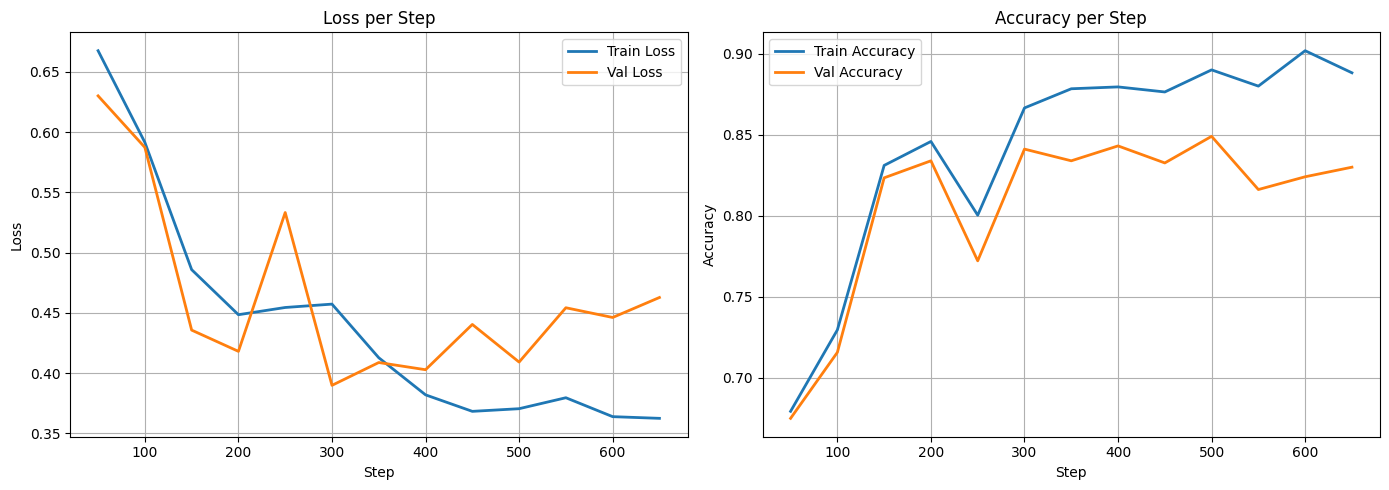

In [18]:
# 학습 로그 정리
log_df = pd.DataFrame(trainer.state.log_history)
train_acc_df = pd.DataFrame(train_metrics_callback.train_log)
log_df = log_df.merge(train_acc_df, on='step', how='left')

# 로그 파일 저장
log_df.to_csv(f'training_log_{model_name}_{current_time}.csv', index=False)

# 필요한 컬럼만 추출하여 정리
log_df_clean = log_df[['step', 'loss', 'eval_loss', 'eval_accuracy', 'train_accuracy']].copy()

# 컬럼명 일관성 있게 변경
log_df_clean.rename(columns={
    'loss': 'train_loss',
    'eval_loss': 'val_loss',
    'eval_accuracy': 'val_accuracy'
}, inplace=True)

# 스텝별 평균 계산 (중복 로그 처리)
summary_df = log_df_clean.groupby('step').mean().reset_index()

# 누락된 컬럼 NaN으로 채우기
for col in ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']:
    if col not in summary_df.columns:
        summary_df[col] = np.nan

# 학습 과정 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 손실 그래프
ax1.plot(summary_df['step'], summary_df['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(summary_df['step'], summary_df['val_loss'], label='Val Loss', linewidth=2)
ax1.set_title('Loss per Step')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# 정확도 그래프
ax2.plot(summary_df['step'], summary_df['train_accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(summary_df['step'], summary_df['val_accuracy'], label='Val Accuracy', linewidth=2)
ax2.set_title('Accuracy per Step')
ax2.set_xlabel('Step')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()